In [1]:
import pandas as pd
import math
import numpy as np
from src import strategy, mwSharpe, dateplot

## Some quick settings

In [2]:
minMaturity = 150   # minimum number of trading days to maturity
putAllocation = .025  # percentage of portfolio allocated to the put options
OTMratio = .90      # OTM ratio of the selected put options

## Import data
This takes some time, the cleaned data csv is still quite large

In [3]:
tradingDates = pd.read_csv("tradingDates.csv", header=None)[0]
tradingDates = pd.to_datetime(tradingDates)
spx = pd.read_csv("SPX.csv")
# clean the S&P500 data
spx = spx.set_index('Date', drop=True)
spx.index = pd.to_datetime(spx.index)
spx = (spx['Open'] + spx['Close']) / 2
# filter S&P500 data
spx = spx[spx.index.isin(tradingDates)]
spxRet = spx.pct_change()

# import data, change date format
data = pd.read_csv("cleaned_data.csv")
data = data.rename(columns={'exdate': 'maturity', 'strike_price': 'strike', 'best_bid': 'bid', 'best_offer': 'offer'})
data['date'] = pd.to_datetime(data['date'])
data['maturity'] = pd.to_datetime(data['maturity'])



## Perform simulation

In [4]:
[portfolioValue, tradingBook] = strategy.simulateStrategy(data, tradingDates, spx, spxRet, putAllocation, minMaturity, OTMratio)


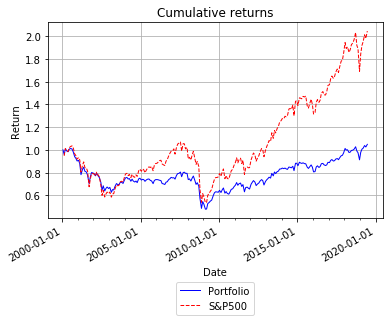

In [5]:
portfolioValue['spx_cumret'] = (1 + spxRet).cumprod()
portfolioRet = portfolioValue['total'].pct_change()

# save the graph by adding: saveLoc='title.png'
dateplot.plotGraph(portfolioValue[['total', 'spx_cumret']], ['Portfolio', 'S&P500'], ylabel='Return', title='Cumulative returns', saveLoc='cumret.png')


## Portfolio performance

In [6]:
print('TOTAL RETURNS')
print('Portfolio: ' + str(np.round(100*portfolioValue['total'][-1],1)) + '%')
print('S&P 500: ' + str(np.round(100*portfolioValue['spx_cumret'][-1],1)) + '%')
print('\n')

print('ANNUALIZED MEAN RETURNS')
portfolioMean = (1+portfolioRet.mean())**12 - 1
spxMean = (1+spxRet.mean())**12 - 1
print('Portfolio: ' + str(np.round(100 * portfolioMean, 2)) + '%')
print('S&P 500: ' + str(np.round(100 * spxMean, 2)) + '%')
print('\n')

print('ANNUALIZED VOLATILITY')
portfolioStd = portfolioRet.std() * math.sqrt(12)
spxStd = spxRet.std() * math.sqrt(12)
print('Portfolio: ' + str(np.round(portfolioStd, 2)))
print('S&P 500: ' + str(np.round(spxStd, 2)))
print('\n')

print('ANNUALIZED SHARPES')
# calculate annualized Sharpe ratios
portfolioSharpe = portfolioMean / portfolioStd
print('Portfolio: ' + str(np.round(portfolioSharpe, 2)))
spxSharpe = spxMean / spxStd
print('S&P 500: ' + str(np.round(spxSharpe,2)))
print('\n')
print('Average loss over each option: ' + str(np.round(100*tradingBook['option return'].mean(),1)) + '%')



TOTAL RETURNS
Portfolio: 104.8%
S&P 500: 204.5%


ANNUALIZED MEAN RETURNS
Portfolio: 1.05%
S&P 500: 5.25%


ANNUALIZED VOLATILITY
Portfolio: 0.13
S&P 500: 0.17


ANNUALIZED SHARPES
Portfolio: 0.08
S&P 500: 0.32


Average loss over each option: -12.0%


## Moving window sharpe ratios
To check if portfolio performance might be better on subsamples (e.g. 2008) --> it doesn't

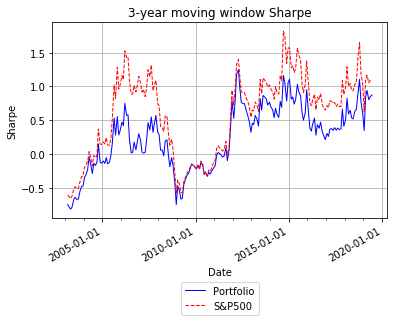

In [7]:
portfolioRet = pd.DataFrame(index = portfolioValue.index)
portfolioRet['portfolio'] = portfolioValue['total'].pct_change()
portfolioRet['spx'] = spxRet
mws = mwSharpe.calc_mw_sharpe(portfolioRet, 36)
dateplot.plotGraph(mws, ['Portfolio', 'S&P500'], ylabel='Sharpe', title='3-year moving window Sharpe', saveLoc='mwSharpe.png')